在本次作业中，你将动手实现课上介绍的 LU 分解算法（课件第10页），雅可比迭代（课件第21-24页）和高斯-塞德尔迭代算法（课件第30-31页），共轭梯度下降算法（课件第35-39页）。本次作业总分为100分。

In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt

# LU 分解算法（30分）

下面是一个高斯消元法（LU分解）的代码示例，你可以观察输出结果，并理解循环是如何工作的

In [2]:
# %%
# define A and b
A = np.array([[2, 1, -1],
        [-3, -1, 2],
        [-2, 1, 2]], dtype='float64')
n = A.shape[0]
b = np.array([8, -11, -3], dtype='float64')

# outplace LU decomposition
L = np.eye(n) # diagonal of L is 1
U = np.zeros_like(A)

for i in range(n):
  for j in range(i, n):
    U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])
  for j in range(i+1, n):
    L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]
  print(f"Step {i}, L = ")
  print(L)
  
print(f"Finished, L = ")
print(L)
print(f"U = ")
print(U)
print(f"LU = ")
print(L @ U)

# solve for x
x = np.zeros(n)
y = np.zeros(n)
# Ly = b
for i in range(n):
  y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]
# Ux = y
for i in range(n-1, -1, -1):
  x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
  
print(f"Solution x = ")
print(x)
print(f"Check b - Ax =")
print(b - A @ x)

Step 0, L = 
[[ 1.   0.   0. ]
 [-1.5  1.   0. ]
 [-1.   0.   1. ]]
Step 1, L = 
[[ 1.   0.   0. ]
 [-1.5  1.   0. ]
 [-1.   4.   1. ]]
Step 2, L = 
[[ 1.   0.   0. ]
 [-1.5  1.   0. ]
 [-1.   4.   1. ]]
Finished, L = 
[[ 1.   0.   0. ]
 [-1.5  1.   0. ]
 [-1.   4.   1. ]]
U = 
[[ 2.   1.  -1. ]
 [ 0.   0.5  0.5]
 [ 0.   0.  -1. ]]
LU = 
[[ 2.  1. -1.]
 [-3. -1.  2.]
 [-2.  1.  2.]]
Solution x = 
[ 2.  3. -1.]
Check b - Ax =
[0. 0. 0.]


接下来，我们需要将上面的过程变成inplace的形式，这样做的好处是我们不需要为L，U，x开辟新的内存空间，而直接在A矩阵内部进行分解，并在b中输出最终的解。请参考课件和上面的示例补充代码中的空缺部分。

In [3]:
# %%
def LU(A):
  n = A.shape[0]
  for k in range(n-1):
    for i in range(k+1, n):
      A[i, k] = A[i, k] / A[k, k]
      for j in range(k+1, n):
        # TODO：your code here
        A[i, j] = A[i, j] - A[i, k] * A[k, j]

  return A

def LUsolve(A, b):
  A = LU(A)
  n = A.shape[0]
  for i in range(1, n):
    # TODO：your code here
    b[i] = b[i] - A[i, :i] @ b[:i]

  for i in range(n-1, -1, -1):
    # TODO：your code here
    b[i] = (b[i] - A[i, i+1:] @ b[i+1:]) / A[i, i]

  return b

In [4]:
# %%
A = np.array([[2, 1, -1],
        [-3, -1, 2],
        [-2, 1, 2]], dtype='float64')
b = np.array([8, -11, -3], dtype='float64')
A0 = np.copy(A)
b0 = np.copy(b)

A = LU(A)
print(f"Finished, A = ")
print(A)
print("Upper triangular of A:")
print(np.triu(A))   
print("Lower triangular of A:")
print(np.tril(A, -1) + np.eye(A.shape[0]))

A = np.copy(A0)
x = LUsolve(A, b)
print(f"Solution x = ")
print(x)
print(f"Check b - Ax =")
print(b0 - A0 @ x)

Finished, A = 
[[ 2.   1.  -1. ]
 [-1.5  0.5  0.5]
 [-1.   4.  -1. ]]
Upper triangular of A:
[[ 2.   1.  -1. ]
 [ 0.   0.5  0.5]
 [ 0.   0.  -1. ]]
Lower triangular of A:
[[ 1.   0.   0. ]
 [-1.5  1.   0. ]
 [-1.   4.   1. ]]
Solution x = 
[ 2.  3. -1.]
Check b - Ax =
[0. 0. 0.]


# 迭代算法（40分）

接下来，我们实现雅可比迭代和高斯-赛德尔迭代，注意比较二者的区别。

In [5]:
# %%
def Jacobi(A, b, max_iter=1000, tol=1e-6):
  n = A.shape[0]
  x = np.zeros(n)
  x_new = np.zeros(n)
  res = [np.linalg.norm(b - A @ x)]
  for _ in range(max_iter):
    # TODO: your code here
    for i in range(n):
      x_new[i] = b[i] - A[i, :i] @ x[:i] - A[i, i+1:] @ x[i+1:]
      x_new[i] /= A[i, i]
    
    x = x_new.copy()

    res.append(np.linalg.norm(b - A @ x))
    if res[-1] < tol:
      break
  return x, res

def GaussSeidel(A, b, max_iter=1000, tol=1e-6):
  n = A.shape[0]
  x = np.zeros(n)
  res = [np.linalg.norm(b - A @ x)]
  for _ in range(max_iter):
    # TODO: your code here
    for i in range(n):
      x[i] = b[i] - A[i, :i] @ x[:i] - A[i, i+1:] @ x[i+1:]
      x[i] /= A[i, i]

    res.append(np.linalg.norm(b - A @ x))
    if res[-1] < tol:
      break
  return x, res

如果实现正确，你应该可以在下面的例子中看到GS比Jacobi更快的收敛速度。

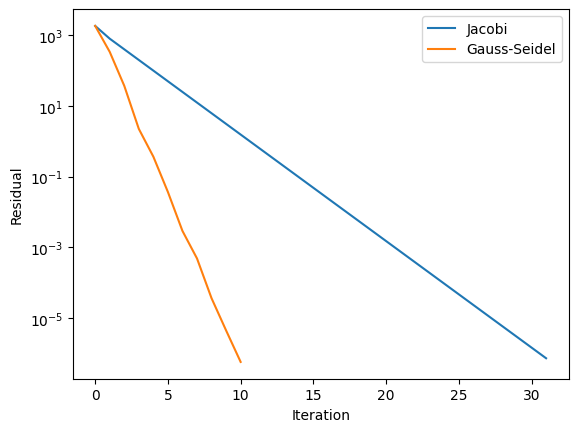

In [6]:
# %%
n = 1000
A = np.random.rand(n, n)
A = A + n*np.eye(n)
b = np.random.rand(n) * 100

x, res = Jacobi(A, b)
x1, res1 = GaussSeidel(A, b)

plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.yscale('log')
plt.plot(res, label='Jacobi')
plt.plot(res1, label='Gauss-Seidel')
plt.legend()

# 共轭梯度下降算法（30分）

下面请实现共轭梯度下降算法。

In [7]:
# %%
def ConjugateGradient(A, b, max_iter=1000, tol=1e-6):
  n = A.shape[0]
  x = np.zeros(n)
  r = b - A @ x
  p = np.copy(r)
  res = [np.linalg.norm(r)]
  for _ in range(max_iter):
    # TODO: your code here
    alpha = (r.T @ r) / (p.T @ A @ p)
    x += alpha * p
    r_next = r - alpha * A @ p

    beta = (r_next @ r_next) / (r @ r)
    p = r_next + beta * p
    
    r = r_next.copy()

    res.append(np.linalg.norm(r))
    if res[-1] < tol:
      break
  return x, res

如果实现正确，你应该能在下面的例子中看到CG比GS更快的收敛速度。

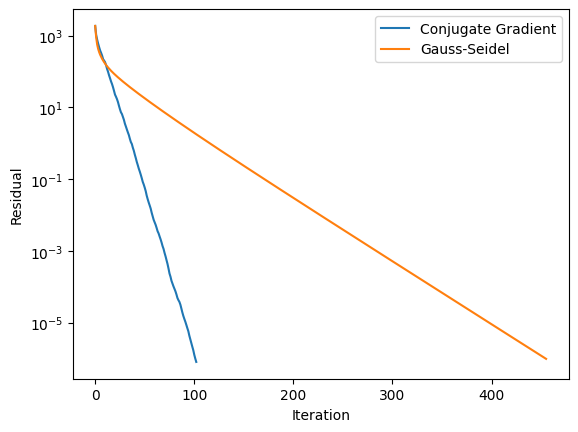

In [8]:
# %%
# random generate othogonal matrix
n = 1000
Q, _ = np.linalg.qr(np.random.rand(n, n))
A = Q.T @ np.diag(np.linspace(1, 100, n)) @ Q

x, res = ConjugateGradient(A, b)
x1, res1 = GaussSeidel(A, b)

plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.yscale('log')
plt.plot(res, label='Conjugate Gradient')
plt.plot(res1, label='Gauss-Seidel')
plt.legend()